# Letters

## Description

Generate an image with the edges of the letters present in this noisy image


## Group 9

* PG53879 - Inês Nogueira Ferreira
* PG54084 - Marta Isabel da Silva e Sá

### Init

In [93]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

(400, 600)


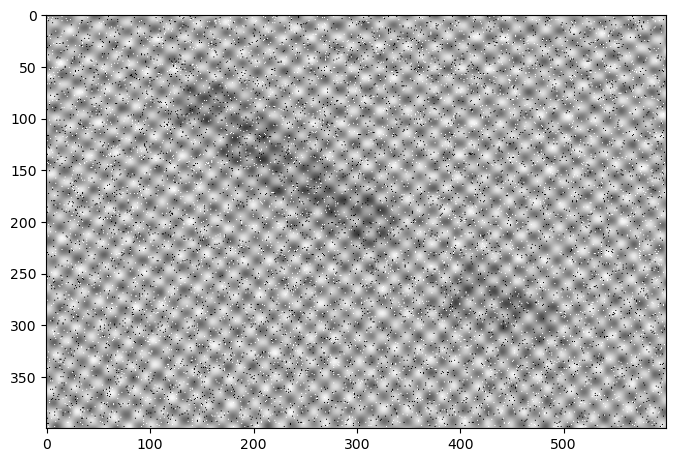

In [94]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
W,H=img.shape
print(img.shape)
ratio=H/W
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

### Notch Filter

aaaaaaaaaaaaaaaaaaaa

In [95]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

DFT Shape = (400, 600, 2)


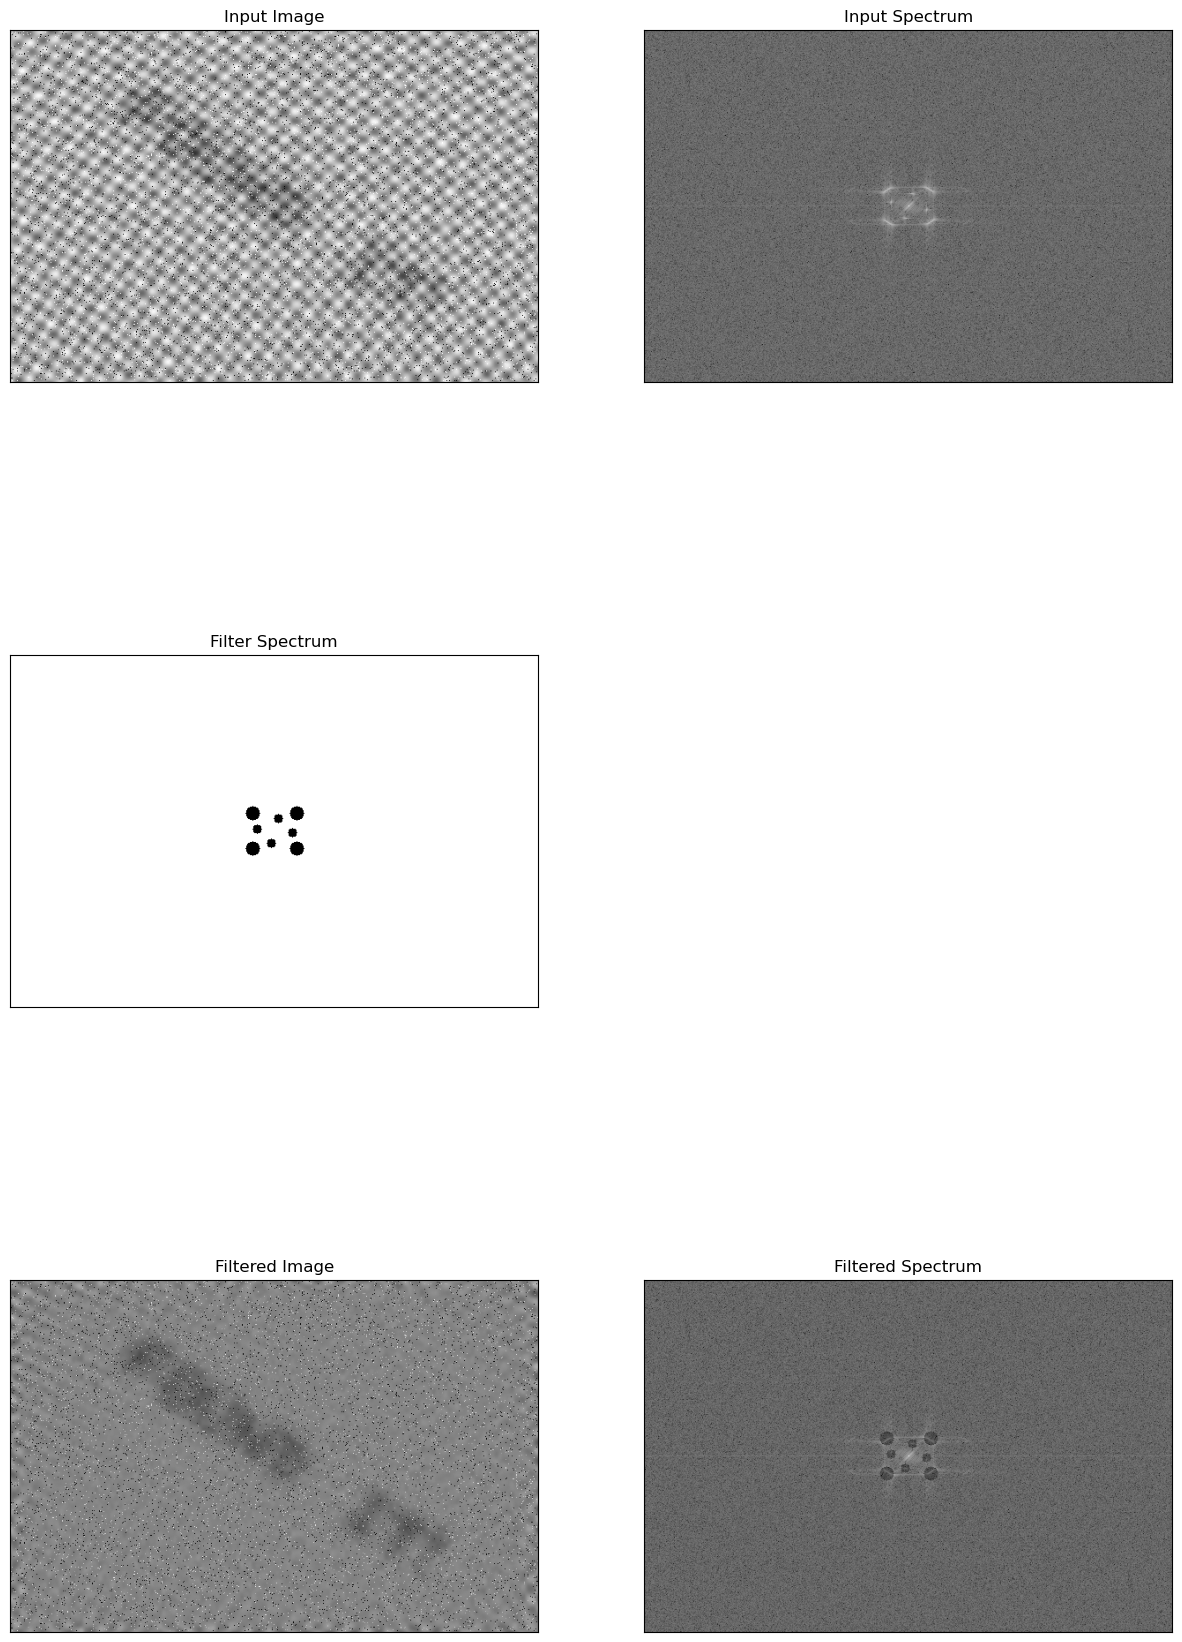

In [96]:
img_float32 = np.float32(img)

# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)

print('DFT Shape =', dft_shift.shape)

# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters

d0_list = [8,8,5,5]                 # raio do nodo
u_k_list = [20,20,-2,14]            # coordenada u do nodo (y)
v_k_list = [25,-25,-20,-4]          # coordenada v do nodo (x)

H = notch_reject_filter_vec(img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec(img.shape, d0, u_k, v_k)
    H *= Haux

# apply mask and inverse DFT<
dft_masked = dft_shift * H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show() 



In [97]:
img_back *= (255.0/img_back.max())
cv2.imwrite('imgNotch.png', img_back)
imgNotch = img_back.astype(np.uint8)

### Gaussian Blur

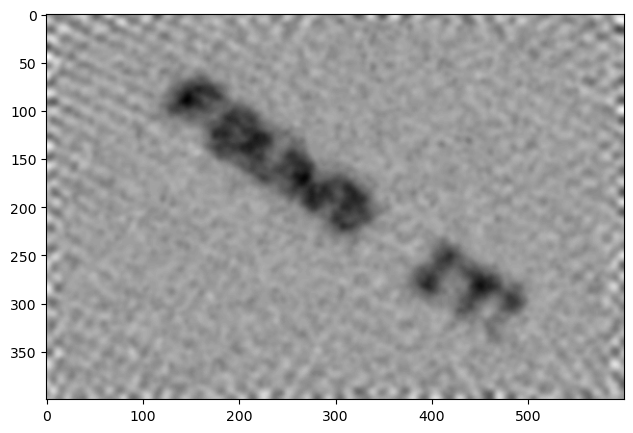

In [98]:
m=17
gauss_blur = cv2.GaussianBlur(imgNotch,(m,m),0)

fig = plt.figure(figsize=(15,5))
plt.imshow(gauss_blur, cmap='gray')

### Fast Denoising

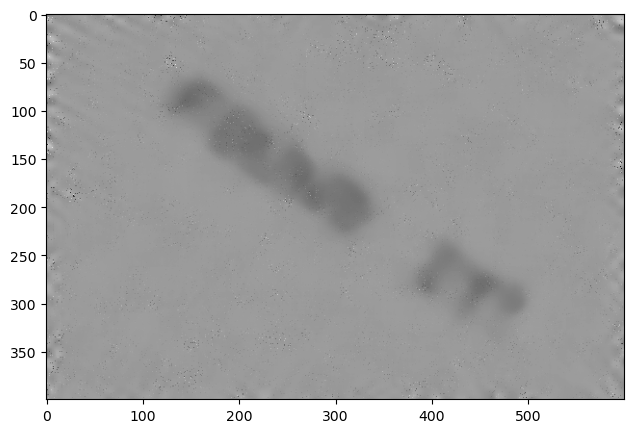

In [99]:
# OpenCV Local Denoising Filter 
means_denoise = cv2.fastNlMeansDenoising(imgNotch,None,15,15,31) # source, destination, h=15, hForColorComponents=27, templateWindowSize=51

fig = plt.figure(figsize=(15,5))
plt.imshow(means_denoise, cmap='gray')

### Median Filter

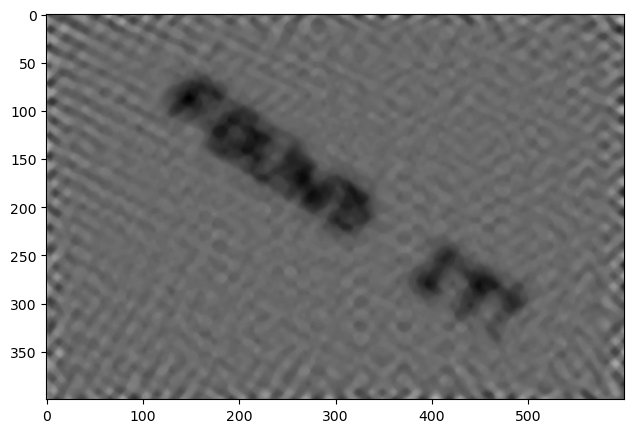

In [100]:
# Filtro de Mediana
m=7
median_filter = cv2.medianBlur(imgNotch,m,0)

fig = plt.figure(figsize=(15,5))
plt.imshow(median_filter, cmap='gray')


### Bilateral

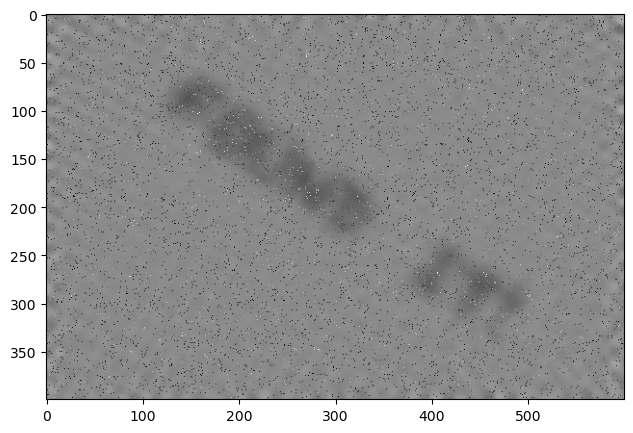

In [101]:
# OpenCV Bilateral Filter 
m=13
sigma_s = 35
sigma_r = 175
dImg = cv2.bilateralFilter(imgNotch, m, sigma_s, sigma_r)

fig = plt.figure(figsize=(15,5))
plt.imshow(dImg, cmap='gray')

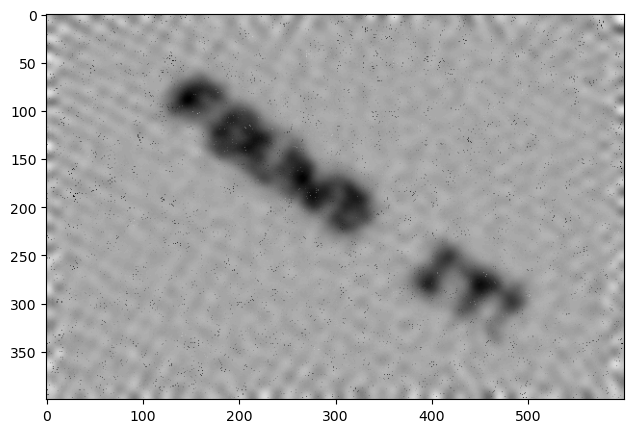

In [102]:
# OpenCV Bilateral Filter 
m=13
sigma_s = 65
sigma_r = 175
dImg2 = cv2.bilateralFilter(dImg, m, sigma_s, sigma_r)

fig = plt.figure(figsize=(15,5))
plt.imshow(dImg2, cmap='gray')

### Histogramas

([], [])

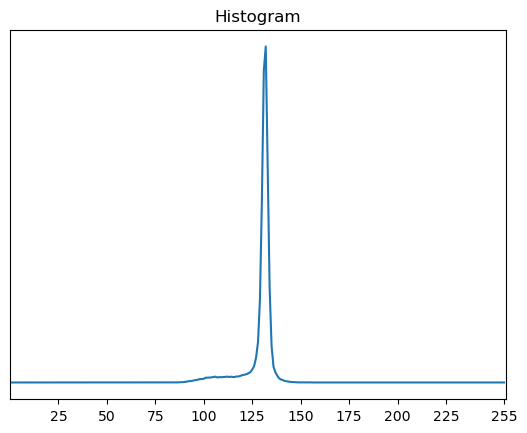

In [103]:
# histogram
hist = cv2.calcHist([dImg2],[0],None,[256],[0,256])


plt.plot(hist)
plt.xlim([0,256])
plt.title('Histogram')
plt.xticks([25,50,75,100,125,150,175,200,225,255]) 
plt.yticks([])

### Sobel

(Text(0.5, 1.0, 'Sobel Y: Absolute'), ([], []), ([], []))

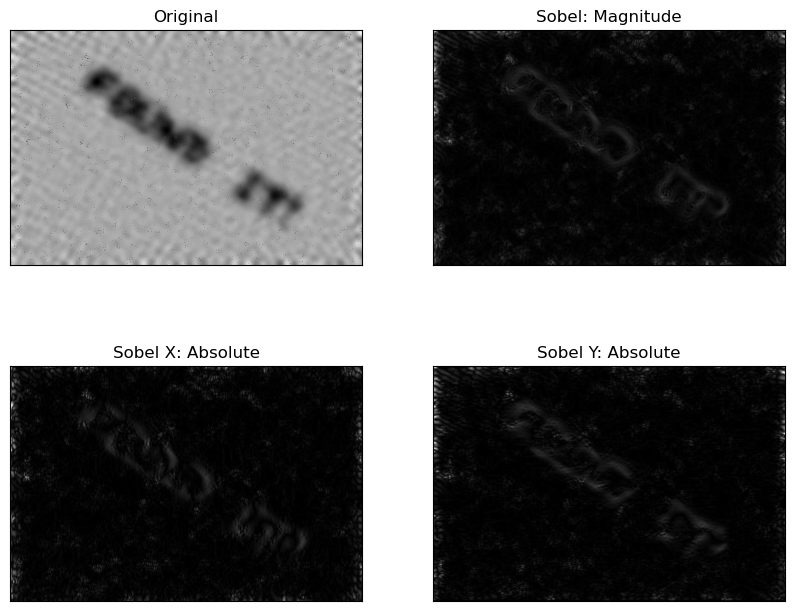

In [104]:
input_sobel = means_denoise

sobelx = cv2.Sobel(input_sobel,cv2.CV_64F,1,0,ksize=9)
sobely = cv2.Sobel(input_sobel,cv2.CV_64F,0,1,ksize=9)

sobel_mag = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))

fig = plt.figure(figsize=(10,8))
plt.subplot(2,2,1),plt.imshow(input_sobel,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobel_mag,cmap = 'gray')
plt.title('Sobel: Magnitude'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(np.abs(sobelx),cmap = 'gray')
plt.title('Sobel X: Absolute'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(np.abs(sobely),cmap = 'gray')
plt.title('Sobel Y: Absolute'), plt.xticks([]), plt.yticks([])

In [ ]:
# Thresholding the gradient
ret,thresh1 = cv2.threshold(sobel_mag,1055,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap = 'gray')
plt.title('Sobel : Magnitude Thresholded'), plt.xticks([]), plt.yticks([])

In [ ]:
c = 0.5
gradImg = c*dImg2 + c*sobel_mag

fig = plt.figure(figsize=(15,5))
plt.imshow(gradImg, cmap='gray')

# Normalize the image
img_norm = cv2.normalize(gradImg, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

### Thresholding

In [ ]:
# Histogram
hist = cv2.calcHist([img_norm],[0],None,[256],[0,256])

# Global
ret, Gthres = cv2.threshold(img_norm,45,255,cv2.THRESH_BINARY)

# Otsu thresholding
ret, Othres = cv2.threshold(img_norm,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Adaptive Thresholdinh
athres = cv2.adaptiveThreshold(img_norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,81,5) # source, max value, adaptive method, threshold type, block size, constant

fig = plt.figure(figsize=(12,18))
plt.subplot(3,2,1),plt.imshow(img_norm,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,2),plt.plot(hist),plt.xlim([0,256])
plt.title('Histogram'), plt.xticks([25,50,75,100,125,150,175,200,225,255]), plt.yticks([])

plt.subplot(3,2,3),plt.imshow(Gthres,cmap = 'gray')
plt.title('Global Thresholding'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,4),plt.imshow(Othres,cmap = 'gray')
plt.title('Otsu Thresholding'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,5),plt.imshow(athres,cmap = 'gray')
plt.title('Adaptive Thresholding'), plt.xticks([]), plt.yticks([])

In [ ]:
edges = cv2.Canny(athres,15,50)

fig = plt.figure(figsize=(15,5))
plt.imshow(edges, cmap='gray')